<a href="https://colab.research.google.com/github/maugarciav/tc3002b-IA/blob/main/ModeloBrainTumor_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thomasdubail/brain-tumors-256x256")

print("Path to dataset files:", path)

100%|██████████| 59.4M/59.4M [00:00<00:00, 81.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1/Data


glioma_tumor  meningioma_tumor	normal	pituitary_tumor


# Data Augmentation

usamos ImageDataGenerator para generar imagenes nuevas en el ram mientras entrenamos para no desperdiciar espacio.

Found 2479 images belonging to 4 classes.
Found 617 images belonging to 4 classes.
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}
Tamaño del conjunto de entrenamiento: 2479
Tamaño del conjunto de validación: 617


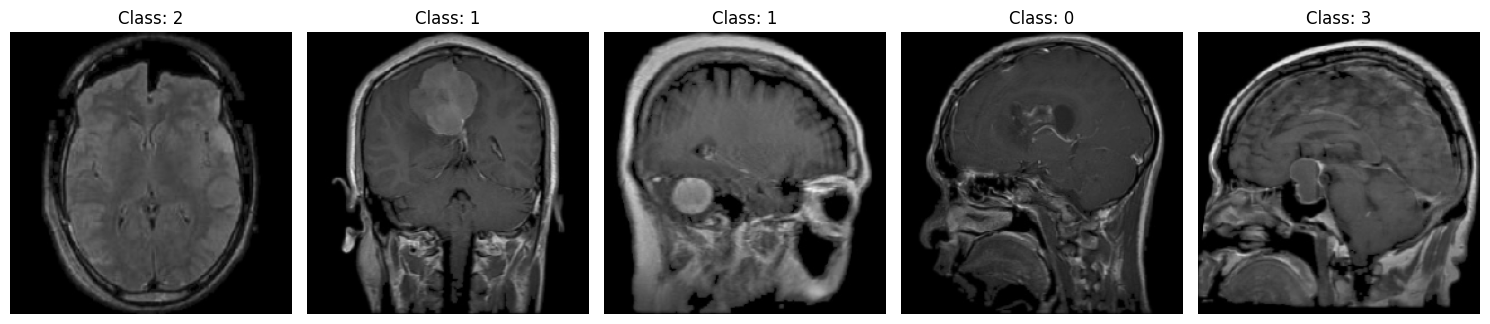

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers



base_dir = '/root/.cache/kagglehub/datasets/thomasdubail/brain-tumors-256x256/versions/1/Data'

# ImageDataGenerator para entrenamiento y validación
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.18,
    horizontal_flip=True,
    validation_split=0.2
)

# Generador para el conjunto de entrenamiento
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=16,
    subset='training',
    class_mode='sparse',
    seed=42,
    shuffle=True
)

# Generador para el conjunto de validación
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=16,
    subset='validation',
    class_mode='sparse',
    seed=42,
    shuffle=False
)

print("Class indices:", train_generator.class_indices)
print("Tamaño del conjunto de entrenamiento:", train_generator.samples)
print("Tamaño del conjunto de validación:", validation_generator.samples)

plt.figure(figsize=(15, 4))
for i in range(5):
    images, labels = next(train_generator)
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[0])
    plt.title(f"Class: {int(labels[0])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Esta es una red neuronal convolutiva:

In [4]:
# Mapeo de índices de clase a nombres de clase
reverse_classes = {v: k for k, v in train_generator.class_indices.items()}
num_classes = len(reverse_classes)

In [5]:
sample_images = []
sample_labels = []
classes_seen = set()

# Iterar sobre el generador hasta obtener una muestra de cada clase
while len(classes_seen) < num_classes:
    images, labels = next(train_generator)
    for i in range(len(labels)):
        label = int(labels[i])
        if label not in classes_seen:
            sample_images.append(images[i])
            sample_labels.append(label)
            classes_seen.add(label)
            if len(classes_seen) == num_classes:
                break
    if len(classes_seen) == num_classes:
        break

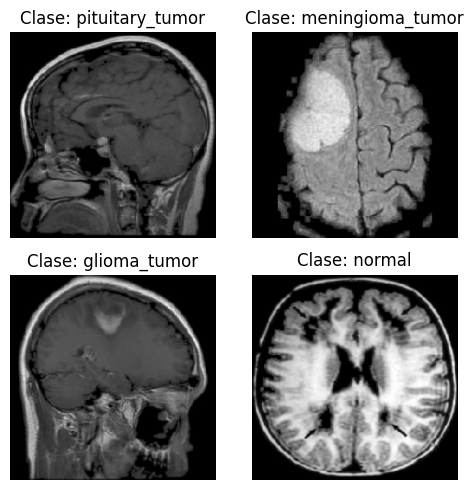

In [25]:
fig = plt.figure(figsize=(5, 5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 2, i + 1)
    plt.imshow(sample_images[i])
    ax.set_title(f'Clase: {reverse_classes[sample_labels[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

train_generator.reset()

In [26]:
from tensorflow.keras import models, layers, optimizers, regularizers

model = models.Sequential()
#model.add(layers.Conv2D(32, (3, 3), activation="relu",kernel_regularizer=regularizers.l2(1e-4), input_shape=(224, 224, 3))) #TEST-1
#model.add(layers.Conv2D(32, (3, 3), activation="relu",kernel_regularizer=regularizers.l2(1e-3), input_shape=(224, 224, 3))) #TEST-2
model.add(layers.Conv2D(32, (3, 3), activation="relu",kernel_regularizer=regularizers.l2(5e-4), input_shape=(224, 224, 3))) #TEST-3
model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(128, (3, 3), activation="relu",kernel_regularizer=regularizers.l2(1e-4))) #TEST-1
#model.add(layers.Conv2D(128, (3, 3), activation="relu",kernel_regularizer=regularizers.l2(1e-3))) #TEST-2
model.add(layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(5e-4))) #TEST-3
model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(128, (3, 3), activation="relu",kernel_regularizer=regularizers.l2(1e-4))) #TEST-1
#model.add(layers.Conv2D(128, (3, 3), activation="relu",kernel_regularizer=regularizers.l2(1e-3))) #TEST-2
model.add(layers.Conv2D(128, (3, 3), activation="relu",kernel_regularizer=regularizers.l2(5e-4))) #TEST-3
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
#model.add(layers.Dropout(0.4)) #TEST-1
#model.add(layers.Dropout(0.5)) #TEST-2
model.add(layers.Dropout(0.45)) #TEST-3

#model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(1e-4))) #TEST-1
#model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(1e-3))) #TEST-2
model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(5e-4))) #TEST-3
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - accuracy: 0.3892 - loss: 1.5465 - val_accuracy: 0.4819 - val_loss: 1.2324
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.6350 - loss: 1.0912 - val_accuracy: 0.6349 - val_loss: 1.0719
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.7371 - loss: 0.8698 - val_accuracy: 0.5888 - val_loss: 1.0913
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.7646 - loss: 0.7757 - val_accuracy: 0.6480 - val_loss: 1.1744
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step - accuracy: 0.7998 - loss: 0.6958 - val_accuracy: 0.7549 - val_loss: 0.8209
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.8491 - loss: 0.5749 - val_accuracy: 0.7500 - val_loss: 0.8369
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.8711 - loss: 0.5383 - val_accuracy: 0.6859 - val_loss: 1.1241
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.9019 - loss: 0

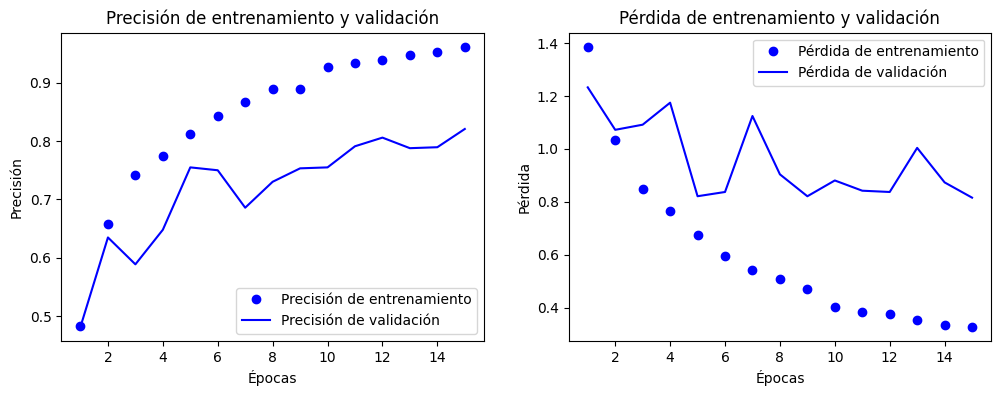

In [27]:
history = model.fit(
						train_generator,
						epochs = 15,
						validation_data=validation_generator,
   					validation_steps=validation_generator.samples // validation_generator.batch_size
						)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [32]:
eval_loss, eval_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'\nPérdida en el conjunto de validación: {eval_loss:.4f}')
print(f'Precisión en el conjunto de validación: {eval_acc:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.7712 - loss: 0.9972

Pérdida en el conjunto de validación: 0.8296
Precisión en el conjunto de validación: 0.8191


In [29]:
# Etiquetas verdaderas y las predicciones para el conjunto de validación
true_labels = validation_generator.classes
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)

# Asegurémonos de que la longitud de las etiquetas predichas coincida con las verdaderas
if len(predicted_classes) > len(true_labels):
    predicted_classes = predicted_classes[:len(true_labels)]
elif len(predicted_classes) < len(true_labels):
    true_labels = true_labels[:len(predicted_classes)]


cm = confusion_matrix(true_labels, predicted_classes)

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step


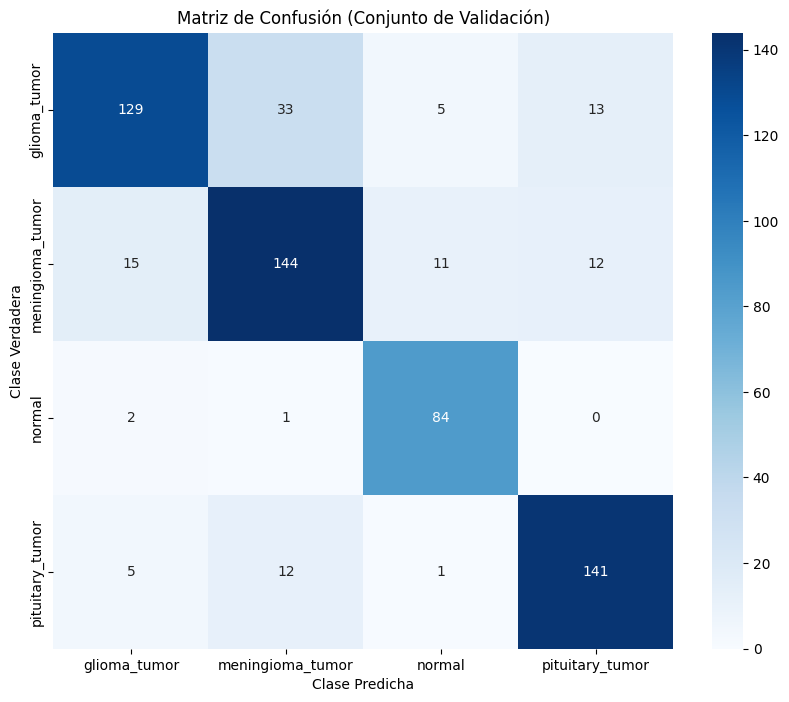

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión (Conjunto de Validación)')
plt.show()

Found 617 images belonging to 4 classes.


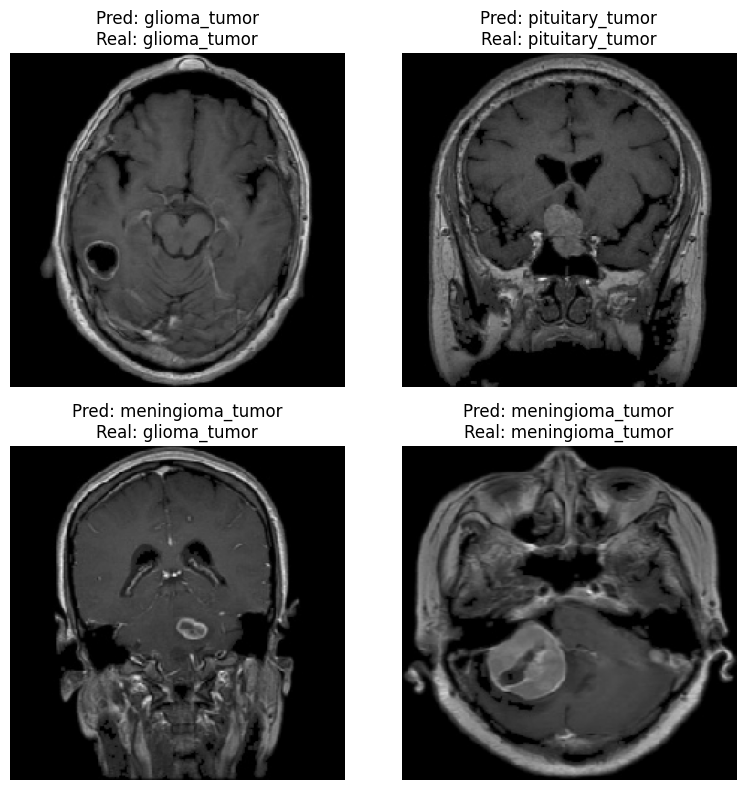

In [31]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

eval_generator_visual = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=4,
    subset='validation',
    class_mode='sparse',
    seed=42,
    shuffle=True
)

class_names = list(eval_generator_visual.class_indices.keys())

images, true_labels = next(eval_generator_visual)
predictions = model.predict(images, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
images_desnormalizadas = (images * 255).astype(np.uint8)


fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
for i in range(eval_generator_visual.batch_size):
    ax = axes[i]
    ax.imshow(images_desnormalizadas[i])
    predicted_label = class_names[predicted_classes[i]]
    true_label = class_names[true_labels[i].astype(int)]
    ax.set_title(f"Pred: {predicted_label}\nReal: {true_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()
